In [1]:
## Uncomment and run this once
#!conda install -c conda-forge os fsspec io os numpy scipy pandas PIL matplotlib boto3

In [2]:
import os
import fsspec
import io
import os
import numpy as np
from scipy.signal import correlate2d
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Specify the S3 bucket and object (file) path
bucket_name = 's3://opera-provisional-products'
aoi = 'D131_ALASKA_Frame383'
object_path_OFF = f"CSLC/pst_adt_common/az_fm_rate/no_az_fm_rate/{aoi}/ifg/igram_20151114-20151208.tif.rgb.png"
object_path_ON = f"CSLC/pst_adt_common/az_fm_rate/with_az_fm_rate/{aoi}/ifg/igram_20151114-20151208.tif.rgb.png"
savedir = '../data'

In [4]:
def stream_png(bucket_name,object_path):
    # Create an S3 filesystem instance
    s3 = fsspec.filesystem('s3',anon=True)

    # Read the image from the public S3 bucket
    with s3.open(f"s3://{bucket_name}/{object_path}", 'rb') as file:
        image_data = file.read()

    # Create an in-memory binary stream for Pillow to open the image
    image_stream = io.BytesIO(image_data)

    return image_stream

In [5]:
def corr2(image1, image2):
    """
    Calculate the 2D correlation coefficient between two matrices.

    Parameters:
    - image1: The first input matrix.
    - image2: The second input matrix.

    Returns:
    - corr: The 2D correlation coefficient.
    """
    # Ensure the input matrices are of the same shape
    if np.shape(image1) != np.shape(image2):
        raise ValueError("Input matrices must have the same shape.")
    else:
        print(f"image1_size:{np.shape(image1)} image2_size:{np.shape(image2)}")

    # Calculate the mean of each input matrix
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)

    # Calculate the correlation coefficient
    numerator = correlate2d(image1 - mean1, image2 - mean2, mode='valid')
    denominator = np.sqrt((correlate2d(image1 - mean1, image1 - mean1, mode='valid') *
                           correlate2d(image2 - mean2, image2 - mean2, mode='valid')))
    
    corr = numerator / denominator

    return corr[0, 0]

In [6]:
# Open the image using Pillow
OFF = Image.open(stream_png(bucket_name,object_path_OFF))
ON = Image.open(stream_png(bucket_name,object_path_ON))

# Split the image into its color channels
RGB_OFF= Image.Image.split(OFF)
RGB_ON = Image.Image.split(ON)

In [7]:
corr = []
# Calculate for the 2D correlation coefficient for each color channel
for i in range(0,3):
    correlation_coefficient = corr2(RGB_OFF[i], RGB_ON[i])
    corr.append(correlation_coefficient)
    print(f"Correlation coefficient: {correlation_coefficient} \n")

print('=================================================')
print(f"Mean correlation coefficient: {np.mean(corr)}")
print('=================================================')

image1_size:(4492, 7131) image2_size:(4492, 7131)
Correlation coefficient: 0.980671582269836 

image1_size:(4492, 7131) image2_size:(4492, 7131)
Correlation coefficient: 0.971820639505381 

image1_size:(4492, 7131) image2_size:(4492, 7131)
Correlation coefficient: 0.9811391172815829 

Mean correlation coefficient: 0.9778771130189332


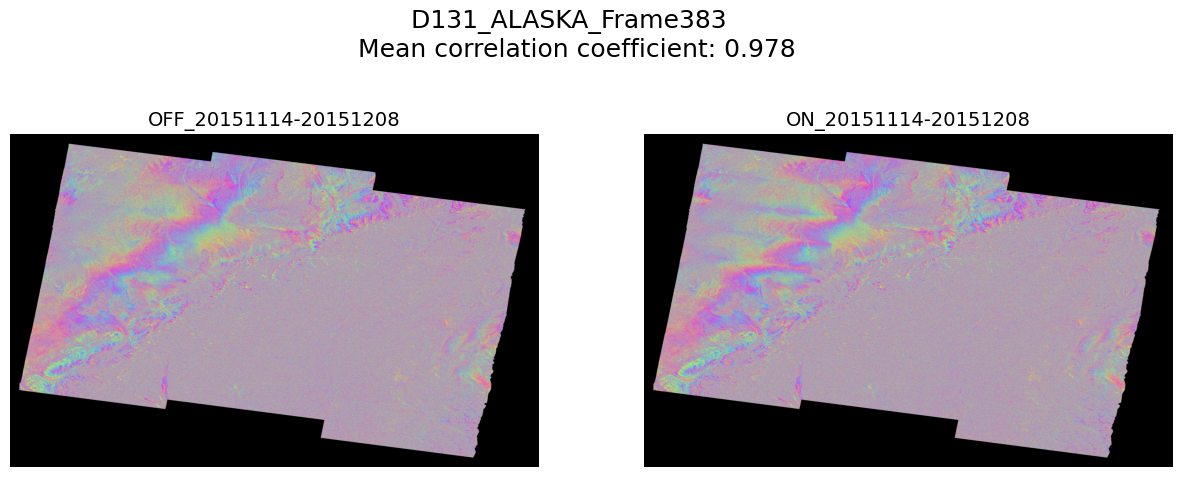

In [8]:
# Display the image using Matplotlib
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(OFF)
ax[0].set_title(f"OFF_{object_path_OFF.split('/')[-1][6:23]}",fontsize=14)
ax[0].axis('off')  # Turn off axis labels and ticks

ax[1].imshow(ON)
ax[1].set_title(f"ON_{object_path_OFF.split('/')[-1][6:23]}",fontsize=14)
ax[1].axis('off')  # Turn off axis labels and ticks

fig.suptitle(f"{object_path_ON.split('/')[4]} \n Mean correlation coefficient: {np.round(np.mean(corr),3)}",fontsize=18) 

# Save the figure
os.makedirs(f"{savedir}/pngs/", exist_ok=True)
fig.savefig(f"{savedir}/pngs/{object_path_ON.split('/')[4]}_{object_path_OFF.split('/')[-1][6:23]}.png")

In [9]:
# Ensure summary directory exists
os.makedirs(f"{savedir}/summary/", exist_ok=True)

# Save summary 
summary = []
ifg = f"{object_path_OFF.split('/')[-1][6:23]}"
mean_corr = np.round(np.mean(corr),3)
summary.append([aoi,ifg, mean_corr])
summary_df = pd.DataFrame(summary)
summary_df.columns=['AOI', 'DATE1-DATE2', 'CORR_COEFF']

#
if os.path.isfile(f'{savedir}/summary/IFG_correlation_coeff.csv')==True:
    summary_df.to_csv(f'{savedir}/summary/IFG_correlation_coeff.csv', mode='a', index=False, header=False)
else:
    summary_df.to_csv(f'{savedir}/summary/IFG_correlation_coeff.csv', mode='a', index=False)

In [10]:
# Close the image streams
OFF.close()
ON.close()